In [13]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import math

from matplotlib.ticker import MaxNLocator
from matplotlib import rc

rc('text', usetex=True)

sns.set_style('ticks')

In [2]:
# planted x
n = 200
x = np.random.uniform(low=-0.5, high=2.0, size=n)
x /= np.linalg.norm(x)

def projX(u):
    theta = np.dot(u, x)
    return (theta/np.dot(x, x)) * x

def projOrthX(u):
    return u - projX(u)

def dist(x, u):
    a = np.linalg.norm(u - x)
    b = np.linalg.norm(u + x)
    return min(a, b)

In [3]:
# RIP measurements

def makeA(n, m):
    ensemble = [np.random.normal(scale=1/np.sqrt(m), size=n*n).reshape((n, n)) for _ in range(m)]
    def A(M):
        """Takes M and returns A(M)
        
        """
        return np.array([np.sum(Ai * M) for i, Ai in enumerate(ensemble)])

    def Astar(b):
        """Takes b and returns A*(b)
        
        """
        ret = np.zeros_like(ensemble[0])
        for bi, Ai in zip(b, ensemble):
            ret += bi * Ai
        return ret
    
    return A, Astar

In [4]:
# draw the map and make the planted measurements
A, Astar = makeA(n, 32*n)
b_true = A(np.outer(x, x))

In [5]:
# check that the RIP is reasonable on x_star
ratio = (np.dot(x, x)**2)/(np.linalg.norm(b_true)**2)
print(ratio, 1/ratio)

1.01228488743 0.98786419951


In [6]:
# define the function f and its gradient

def f(u):
    err = A(np.outer(u, u)) - b_true
    return 0.25*np.dot(err, err)

def df(u):
    err = A(np.outer(u, u)) - b_true
    ATA = Astar(err)
    return 0.5*(ATA + ATA.T).dot(u)

In [7]:
# define sampling distributions

def unif_on_sphere(n):
    """Uniform on n-dim sphere"""
    g = np.random.normal(size=n)
    return g/np.linalg.norm(g)


def unif_on_ball(n):
    """Uniform on n-dim L2 ball"""
    
    U = np.random.uniform()
    r = math.pow(U, 1/n)
    return r * unif_on_sphere(n)

In [8]:
def policy_adapt(ucur):
    mu = (np.dot(ucur, ucur) + np.dot(x, x))
    return 1/mu

def policy_standard(ucur):
    mu = np.dot(x, x)
    return 1/(2*mu)

def make_random_trajectories(n_trajs, sampling_dist, step_policy):
    trajectories = []
    for _ in range(n_trajs):

        ustart = sampling_dist(n)
        ucur = np.array(ustart)
        trials = 20
        
        def compute_info(u):
            return ((np.dot(x, u), np.linalg.norm(projOrthX(u))), dist(x, u))
        
        this_traj = [compute_info(ucur)]
        
        for trial in range(trials):
            eta = step_policy(ucur)
            ucur = ucur - eta * df(ucur)
            this_traj.append(compute_info(ucur))
        
        trajectories.append(this_traj)
        
    return trajectories

In [9]:
# sample trajectories--
# this might take a while
trajectories = make_random_trajectories(16, unif_on_sphere, policy_standard)

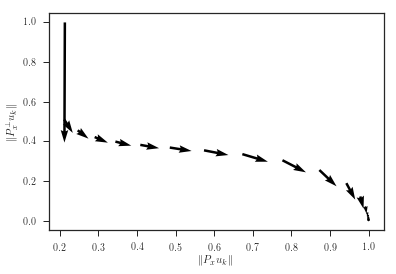

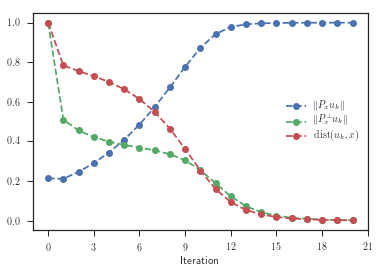

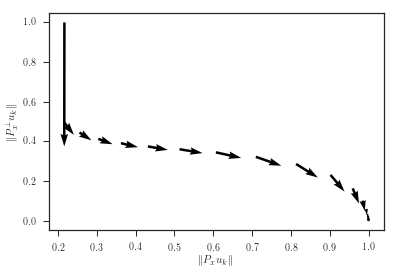

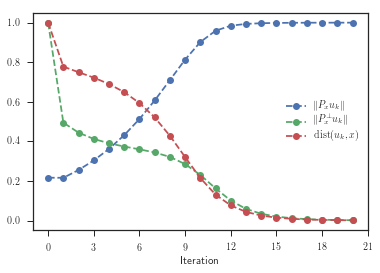

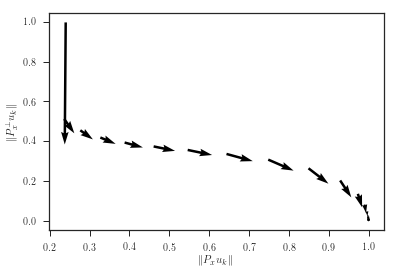

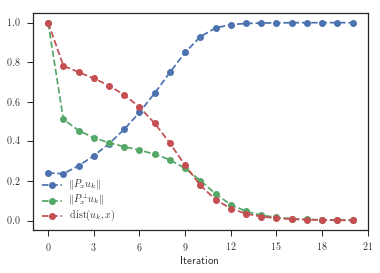

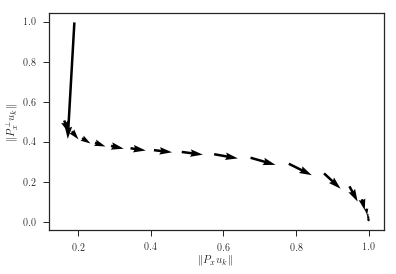

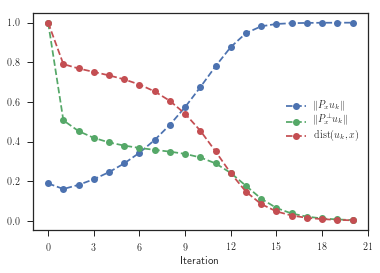

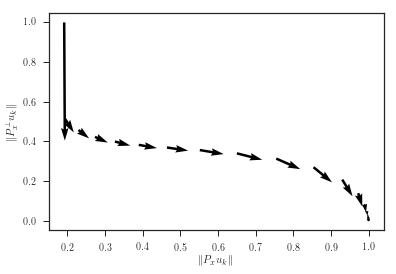

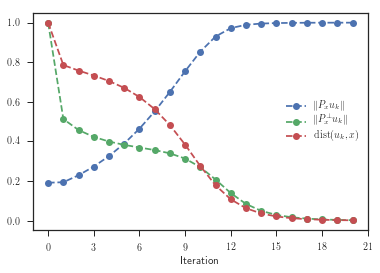

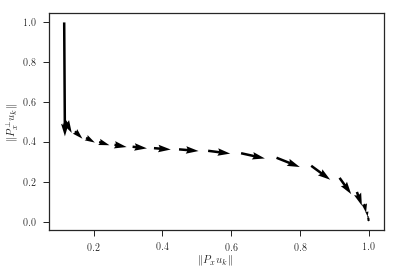

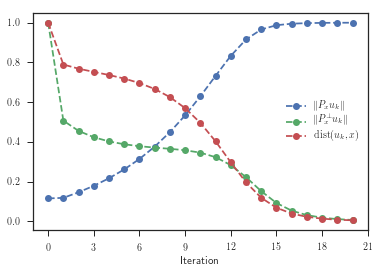

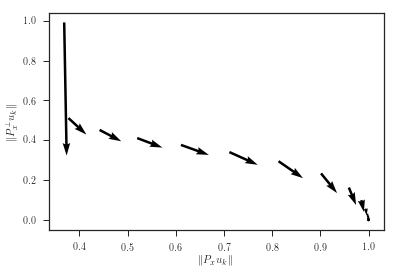

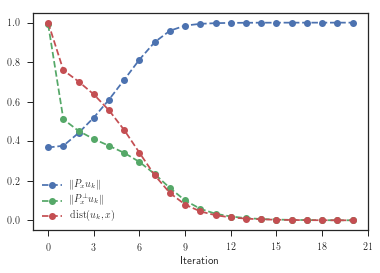

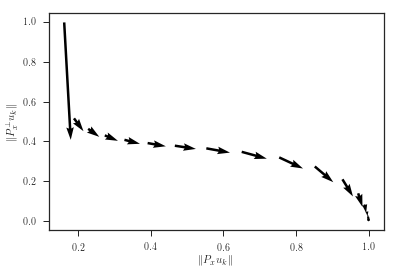

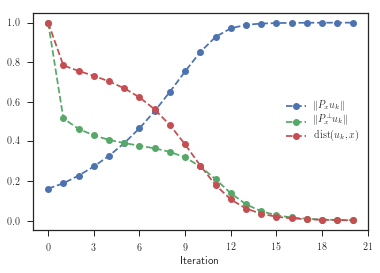

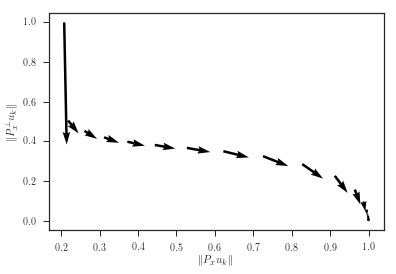

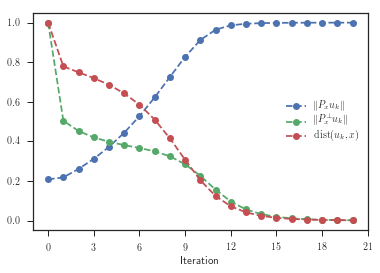

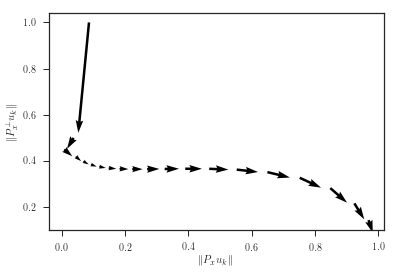

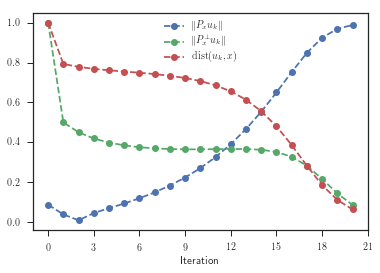

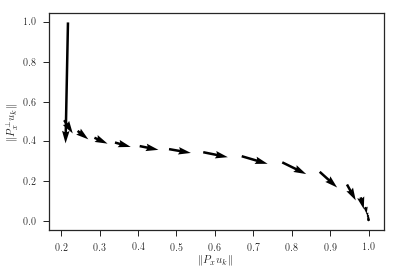

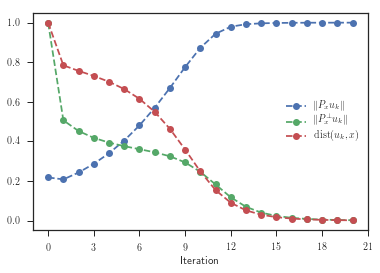

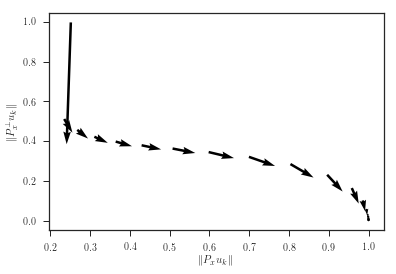

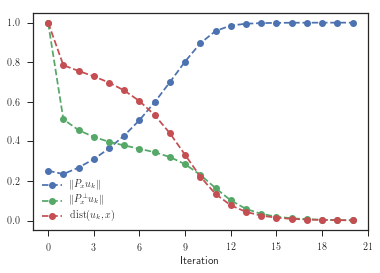

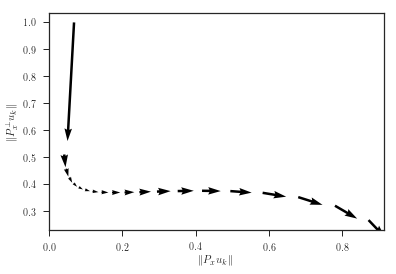

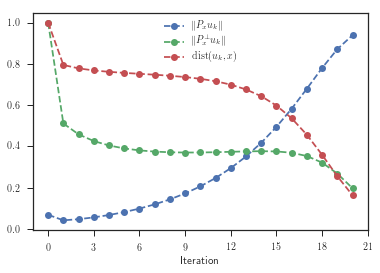

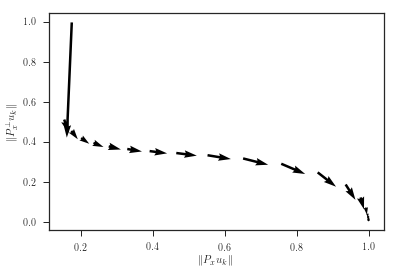

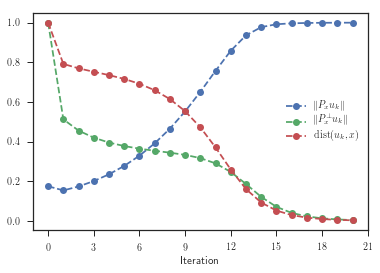

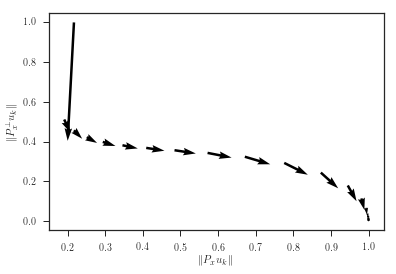

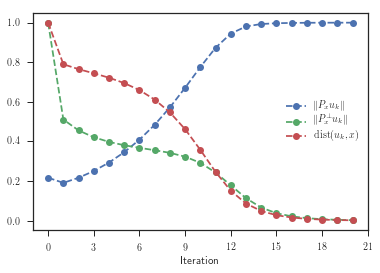

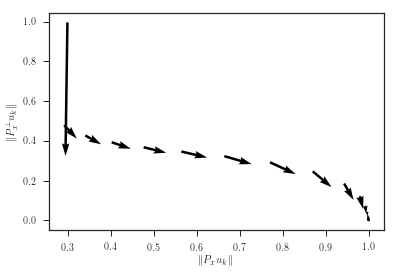

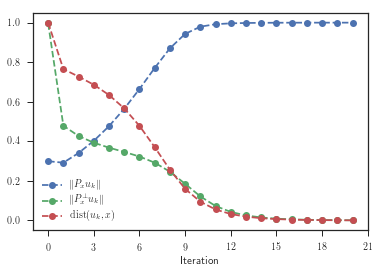

In [14]:
# plot all trajectories

for this_traj in trajectories:
    coord_x, coord_y = (
        np.array([np.sqrt(np.abs(e1)) for ((e1, _), _) in this_traj]), 
        np.array([e2 for ((_, e2), _) in this_traj])
    )
    err = np.array([err for _, err in this_traj])
    
    plt.quiver(coord_x[:-1], coord_y[:-1], coord_x[1:]-coord_x[:-1], coord_y[1:]-coord_y[:-1])
    plt.xlabel(r'$\| P_x u_k \|$')
    plt.ylabel(r'$\|P^\perp_x u_k\|$')
    plt.show()
    
    plt.plot(np.arange(len(coord_x)), coord_x, 'o--',
             np.arange(len(coord_y)), coord_y, 'o--',
             np.arange(len(err)), err/err[0], 'o--')
    plt.xlabel('Iteration')
    plt.legend((r'$\| P_x u_k \|$', r'$\|P^\perp_x u_k\|$', r'$\mathrm{dist}(u_k, x)$'))
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [15]:
# Get representative trajectory and save to PNG
this_traj = trajectories[-1]
coord_x, coord_y = (
    np.array([np.sqrt(np.abs(e1)) for ((e1, _), _) in this_traj]), 
    np.array([e2 for ((_, e2), _) in this_traj]) 
)
err = np.array([err for _, err in this_traj])

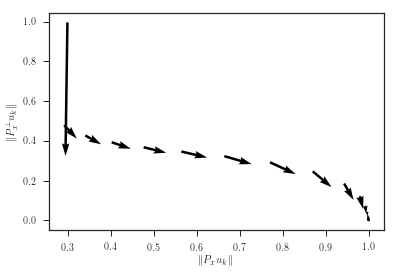

In [16]:
plt.quiver(coord_x[:-1], coord_y[:-1], coord_x[1:]-coord_x[:-1], coord_y[1:]-coord_y[:-1])
plt.xlabel(r'$\| P_x u_k \|$')
plt.ylabel(r'$\|P^\perp_x u_k\|$')
plt.savefig('phasespace.png', dpi=300)

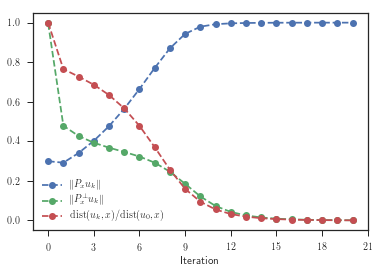

In [17]:
plt.plot(np.arange(len(coord_x)), coord_x, 'o--',
         np.arange(len(coord_y)), coord_y, 'o--',
         np.arange(len(err)), err/err[0], 'o--')
plt.xlabel('Iteration')
plt.legend((r'$\| P_x u_k \|$', r'$\|P^\perp_x u_k\|$', r'$\mathrm{dist}(u_k, x)/\mathrm{dist}(u_0, x)$'))
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('potentials.png', dpi=300)

## Plot Regions

In [20]:
def perp_decrease_region(x, y):
    delta = 1/20
    lhs = delta*delta*( (x**2 + y**2)**2 + 1 - 2*(x**2) )
    rhs = (x**2 + y**2)*(y**2)
    return lhs < rhs

def parallel_increase_region(x, y):
    beta = 1/2
    delta = 1/20
    LHS = (
        np.abs(1 - beta*((x**2) + (y**2) - 1)) 
        - beta*delta*np.sqrt((x**2) + (y**2))*np.sqrt( ((x**2) + (y**2))**2 + 1 - 2*(x**4) )/(x**2)
    )
    return LHS > 1

def strong_convexity_reegion(x, y):
    return (x**2 + y**2 + 1 - 2*x) <= 1/16

In [25]:
grid = np.linspace(1e-5, 1, 200)
dec_points = []
inc_points = []
sc_points = []

for x in grid:
    for y in grid:
        if perp_decrease_region(x, y):
            dec_points.append((x, y))
        if parallel_increase_region(x, y):
            inc_points.append((x, y))
        if strong_convexity_reegion(x, y):
            sc_points.append((x, y))

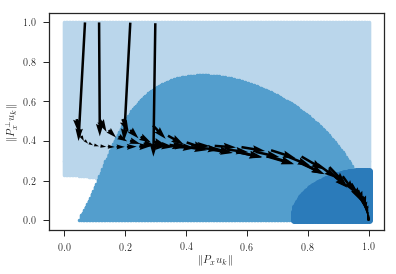

In [26]:
x_dec_vec = np.array([e[0] for e in dec_points])
y_dec_vec = np.array([e[1] for e in dec_points])
fig = plt.figure()
plt.plot(x_dec_vec, y_dec_vec, color=sns.color_palette('Blues')[1], marker='.')

x_inc_vec = np.array([e[0] for e in inc_points])
y_inc_vec = np.array([e[1] for e in inc_points])
plt.plot(x_inc_vec, y_inc_vec, color=sns.color_palette('Blues')[3], marker='.')

x_sc_vec = np.array([e[0] for e in sc_points])
y_sc_vec = np.array([e[1] for e in sc_points])
plt.plot(x_sc_vec, y_sc_vec, color=sns.color_palette('Blues')[4], marker='o')

# specific choices are arbitrary here
trajs = [
    trajectories[-1],
    trajectories[-2],
    trajectories[-4],
    trajectories[5]
]

for this_traj in trajs:
    coord_x, coord_y = (
        np.array([np.sqrt(np.abs(e1)) for ((e1, _), _) in this_traj]), 
        np.array([e2 for ((_, e2), _) in this_traj])
    )
    err = np.array([err for _, err in this_traj])
    plt.quiver(coord_x[:-1], coord_y[:-1], coord_x[1:]-coord_x[:-1], coord_y[1:]-coord_y[:-1], figure=fig, zorder=100)

plt.xlabel(r'$\| P_x u_k \|$')
plt.ylabel(r'$\|P^\perp_x u_k\|$')
plt.savefig('overlay.png', dpi=300)